# DeepGlobe Land Cover Segmentation

In [1]:
# import the required libraries
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import zipfile  # import module to unzip the data
import urllib.request
import os  # import module to access file paths

In [2]:
# zf = zipfile.ZipFile("data.zip")
# zf.extractall()

In [3]:
path = os.getcwd()
path = datapath4file(path+'/data')
path.ls()

[PosixPath('/home/ubuntu/course-v3/nbs/data/images'),
 PosixPath('/home/ubuntu/course-v3/nbs/data/.DS_Store'),
 PosixPath('/home/ubuntu/course-v3/nbs/data/gs_labels')]

In [4]:
path_img = path/'images'
path_gslbl = path/'gs_labels'

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/ubuntu/course-v3/nbs/data/images/68078.jpg'),
 PosixPath('/home/ubuntu/course-v3/nbs/data/images/234269.jpg'),
 PosixPath('/home/ubuntu/course-v3/nbs/data/images/397351.jpg')]

In [6]:
lbl_names = get_image_files(path_gslbl)
lbl_names[:3]

[PosixPath('/home/ubuntu/course-v3/nbs/data/gs_labels/858771_mask.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/data/gs_labels/888343_mask.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/data/gs_labels/958243_mask.png')]

In [7]:
#import glob
#import os

#for f in glob.glob('*_sat.jpg',recursive= True):
#    new_filename = f.replace("_sat","")
#    os.rename(f,new_filename)

#cd ../

In [8]:
# %reload_ext autoreload
# %autoreload 2
# %matplotlib inline
# import PIL.Image as PilImage

# def getClassValues(label_names):

#     containedValues = set([])

#     for i in range(len(label_names)):
#         tmp = open_mask(label_names[i])
#         tmp = tmp.data.numpy().flatten()
#         tmp = set(tmp)
#         containedValues = containedValues.union(tmp)
    
#     return list(containedValues)

# def replaceMaskValuesFromZeroToN(mask, containedValues):
#     numberOfClasses = len(containedValues)
#     newMask = np.zeros(mask.shape)

#     for i in range(numberOfClasses):
#         newMask[mask == containedValues[i]] = i
        
#     return newMask

# def convertMaskToPilAndSave(mask, saveTo):

#     imageSize = mask.squeeze().shape

#     im = PilImage.new('L',(imageSize[1],imageSize[0]))
#     im.putdata(mask.astype('uint8').ravel())
#     im.save(saveTo)

# def convertMasksToGrayscaleZeroToN(pathToLabels,saveToPath):

#     label_names = get_image_files(pathToLabels)
#     containedValues = getClassValues(label_names)

#     for currentFile in label_names:
#         currentMask = open_mask(currentFile).data.numpy()
#         convertedMask = replaceMaskValuesFromZeroToN(currentMask, containedValues)
#         convertMaskToPilAndSave(convertedMask, saveToPath/f'{currentFile.name}')
    
#     print('Conversion finished!')

In [9]:
# convertMasksToGrayscaleZeroToN(path_lbl, path_gslbl)

In [10]:
get_y_fn = lambda x: path_gslbl/f'{x.stem}_mask.png'

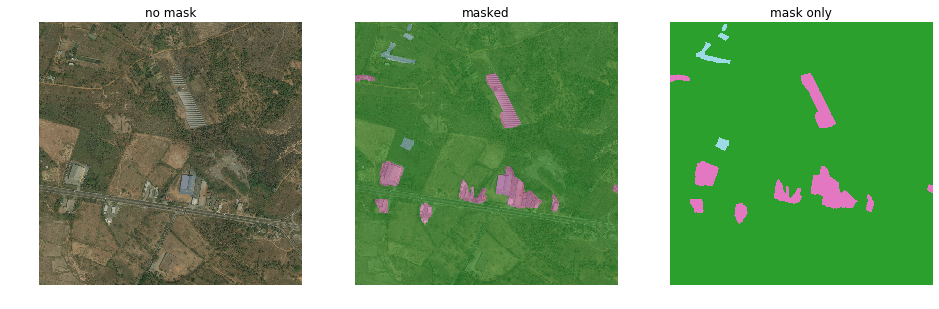

In [11]:
_,axs = plt.subplots(1,3, figsize=(16,8))

img_f = fnames[6]
img = open_image(img_f)
mask = open_mask(get_y_fn(img_f))

img.show(ax=axs[0], title='no mask')
img.show(ax=axs[1], y=mask, title='masked')
mask.show(ax=axs[2], title='mask only', alpha=1.)

In [12]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([2448, 2448]), tensor([[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]]]))

In [13]:
size = src_size//4

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=4
else:           bs=2
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 11430MB of GPU RAM free


In [14]:
classes = ['Unknown',
'Agriculture',
'Rangeland',
'Urban',   
'Forest',
'Water',
'Barren',
]; classes

['Unknown', 'Agriculture', 'Rangeland', 'Urban', 'Forest', 'Water', 'Barren']

In [15]:
src = (SegmentationItemList.from_folder(path_img)
       #Where to find the data? -> in path_img and its subfolders
       .split_by_rand_pct(valid_pct = 0.2, seed = 2019)
       #How to split in train/valid? -> randomly with the default 20% in valid
       .label_from_func(get_y_fn, classes=classes))
       #How to label? -> use the label function on the file name of the data       

In [16]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
         #Data augmentation? -> use tfms with a size of 128, also transform the label images
        .databunch(bs=bs)
         #Finally -> use the defaults for conversion to databunch
        .normalize(imagenet_stats))

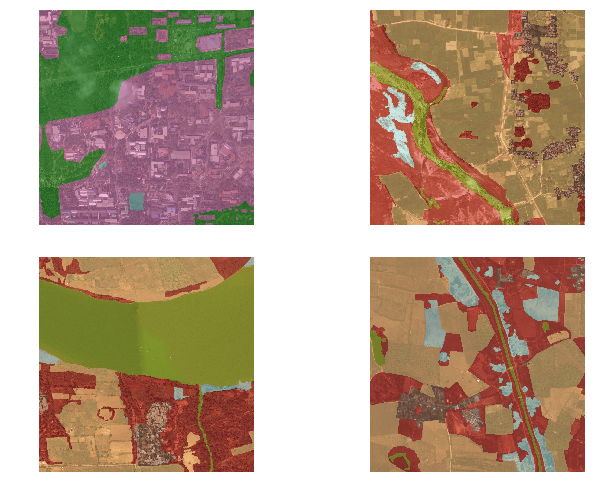

In [17]:
data.show_batch(2, figsize=(10,7))

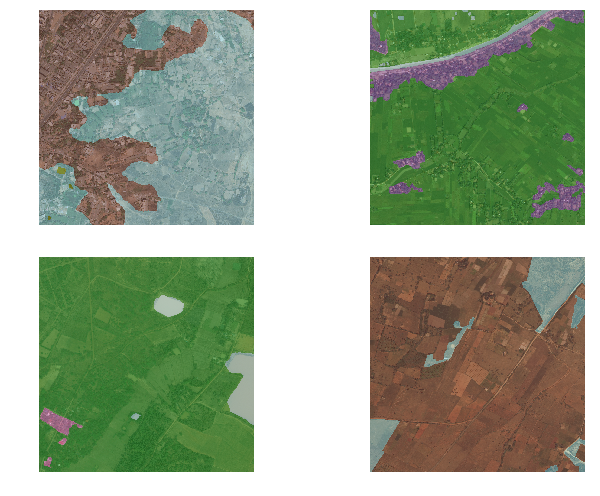

In [18]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [17]:
name2id = {v:k for k,v in enumerate(classes)}
unkown_code = name2id['Unknown']

def acc_deepglobe(input, target):
    target = target.squeeze(1)
    mask = target != unkown_code
    return (input.argmax(dim = 1)[mask]==target[mask]).float().mean()

In [18]:
metrics = acc_deepglobe
#metrics=accuracy

In [19]:
learn = unet_learner(data, models.resnet34, metrics=acc_deepglobe)

For more information on U NET model check out the [original paper](https://arxiv.org/pdf/1505.04597.pdf).

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-05


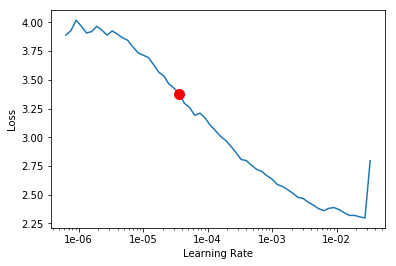

In [20]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [21]:
lr = 3.63E-05
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,acc_deepglobe,time
0,1.396634,1.105883,0.638706,10:04
1,0.992742,0.732260,0.756115,10:03
2,0.822620,0.646763,0.783174,10:02
3,0.787090,0.683092,0.778795,10:02


In [22]:
learn.save('resnet34_mod_01') 

In [ ]:
#learn.load('resnet34_mod_01')

In [25]:
#learn.show_results(rows=3, figsize=(10,10))

In [ ]:
#learn.unfreeze()
#lrs = slice(lr/400,lr/4)
#learn.fit_one_cycle(12, lrs, pct_start=0.8)

In [ ]:
#learn.save('stageresnet34_mod_02');

In [ ]:
#learn.show_results(rows=3, figsize=(10,10))

## Mix precsion training 

In [ ]:
#learn = unet_learner(data, models.resnet34, metrics=metrics).to_fp16()